In [1]:
import pandas as pd
import pyspark
import networkx as nx
import json
from geopandas import GeoDataFrame
from shapely.geometry import Point
import numpy as np
from pyspark.sql import SparkSession
import pickle
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,BooleanType,DoubleType
from pyspark.sql.functions import *
from matplotlib import pyplot as plt
%matplotlib inline

/Users/devashishkhulbe/opt/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
pyspark.__version__

'3.3.0'

In [3]:
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("PySpark Read JSON") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/11 16:47:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# load data

df = spark.read.json('traffic-2022-02.ndjson')

In [5]:
df.show()

+---------+---------+--------------------+----------+--------------------+------------+-----------------+--------------+--------------------+
|avg_speed|intensity|    segment_fullname|segment_id|    segment_location|segment_name|segment_road_name|speed_variance|           timestamp|
+---------+---------+--------------------+----------+--------------------+------------+-----------------+--------------+--------------------+
|    76.12|        9|D00-001: Praha-Sa...|  40000000|{50.1134674023, 1...|     D00-001|               D0|         55.82|2022-01-17T19:00:00Z|
|    79.09|       45|D00-001: Praha-Sa...|  40000000|{50.1134674023, 1...|     D00-001|               D0|         46.57|2022-01-17T19:00:00Z|
|     84.1|        8|D00-001: Praha-Ch...|  40000001|{50.1143633627, 1...|     D00-001|               D0|         18.19|2022-01-17T19:00:00Z|
|    82.36|       38|D00-001: Praha-Ch...|  40000001|{50.1143633627, 1...|     D00-001|               D0|         25.11|2022-01-17T19:00:00Z|
|    8

## Some data stats and basic visulizations

In [6]:
# row count
df.count()

10250001

In [7]:
# unique segments
df.select('segment_id').distinct().count()

2241

In [8]:
df.select('segment_fullname').distinct().count()

2234

In [9]:
# segment_names with locations
segments_name = df.select('segment_name', 'segment_location').drop_duplicates().toPandas()
segments_name.head()

,segment_name,segment_location
0,D01-020,"(49.4530322551, 15.6058254462)"
1,D01-050,"(49.5447066147, 17.5593928334)"
2,D08-011,"(50.6499378043, 13.9922545547)"
3,I11-002,"(50.2127866153, 15.7840739706)"
4,I12-008,"(50.0669999223, 14.835460568)"


In [10]:
segments_name = segments_name.drop_duplicates(subset='segment_name', keep='first')
segments_name.segment_location = tuple(segments_name.segment_location)
segments_name.to_csv('segment_name_loc.csv', index=False)

In [11]:
# segments with locations
segments = df.select('segment_name', 'segment_location').drop_duplicates().toPandas()
segments.head()

,segment_name,segment_location
0,D01-020,"(49.4530322551, 15.6058254462)"
1,D01-050,"(49.5447066147, 17.5593928334)"
2,D08-011,"(50.6499378043, 13.9922545547)"
3,I11-002,"(50.2127866153, 15.7840739706)"
4,I12-008,"(50.0669999223, 14.835460568)"


In [12]:
segments['lat'] = segments['segment_location'].apply(lambda x: x[0])
segments['lon'] = segments['segment_location'].apply(lambda x: x[1])
segments['lat'] = segments.lat.astype(float)
segments['lon'] = segments.lon.astype(float)
geometry = [Point(xy) for xy in zip(segments.lon, segments.lat)]
segments_gdf = GeoDataFrame(segments, crs="EPSG:4326", geometry=geometry)

Text(0.5, 1.0, 'segment locations')

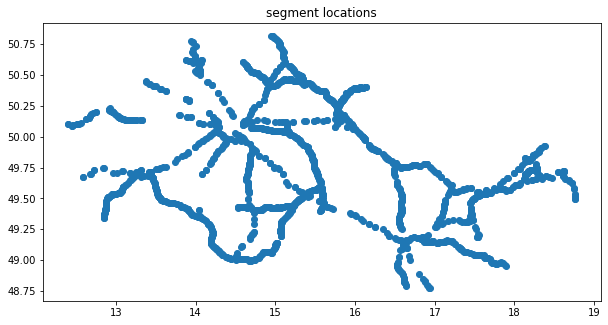

In [13]:
# plot segments
ax = segments_gdf.plot(figsize=(10, 10))
ax.set_title('segment locations')

In [35]:
segments_gdf

,segment_name,segment_location,lat,lon,geometry
0,D01-020,"(49.4530322551, 15.6058254462)",49.453032,15.605825,POINT (15.60583 49.45303)
1,D01-050,"(49.5447066147, 17.5593928334)",49.544707,17.559393,POINT (17.55939 49.54471)
2,D08-011,"(50.6499378043, 13.9922545547)",50.649938,13.992255,POINT (13.99225 50.64994)
3,I11-002,"(50.2127866153, 15.7840739706)",50.212787,15.784074,POINT (15.78407 50.21279)
4,I12-008,"(50.0669999223, 14.835460568)",50.067000,14.835461,POINT (14.83546 50.06700)
...,...,...,...,...,...
2225,D11-015,"(50.3125934812, 15.8533733569)",50.312593,15.853373,POINT (15.85337 50.31259)
2226,D48-011,"(49.6618610171, 18.3384611526)",49.661861,18.338461,POINT (18.33846 49.66186)
2227,D48-011,"(49.6605655023, 18.3439252741)",49.660566,18.343925,POINT (18.34393 49.66057)
2228,D56-007,"(49.6753122615, 18.3223923243)",49.675312,18.322392,POINT (18.32239 49.67531)


In [14]:
# unique segment names
df.select('segment_name').distinct().count()

1128

In [15]:
newDf = df.select('avg_speed', 'segment_name', 'segment_location', 
         'segment_road_name', 'speed_variance').toDF('avg_speed', 'segment_name', 'segment_location', 
         'segment_road_name', 'speed_variance')

In [16]:
# avg speed stats

newDf.describe('avg_speed').show()

+-------+------------------+
|summary|         avg_speed|
+-------+------------------+
|  count|          10250001|
|   mean| 78.81880860889744|
| stddev|10.377966900687749|
|    min|                 0|
|    max|             99.99|
+-------+------------------+



In [18]:
segment_avgSpd = newDf.groupby('segment_name').agg({'avg_speed': 'mean'}).toPandas()
avg_speed = segments_gdf.merge(segment_avgSpd, on='segment_name')

In [19]:
# avg_speed.drop_duplicates(subset=['segment_name', 
#                                   'avg(avg_speed)'])[['segment_name', 'avg(avg_speed)']].to_csv('segment_name_speed')

Text(0.5, 1.0, 'avg speed by segment')

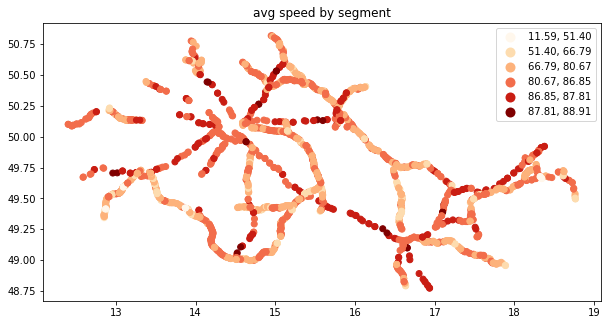

In [20]:
ax = avg_speed.plot(column='avg(avg_speed)', cmap='OrRd', k=10, scheme='Percentiles', figsize=(10, 10), 
                    legend=True)
ax.set_title('avg speed by segment')

In [24]:
# plot avg intensity by segments

segment_avgIntensity = df.groupby('segment_name').agg({'intensity': 'mean'}).toPandas()
avg_intensity = segments_gdf.merge(segment_avgIntensity, on='segment_name')

Text(0.5, 1.0, 'avg intensity by segment')

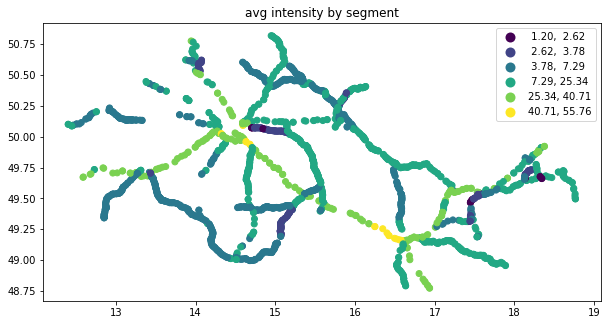

In [25]:
ax = avg_intensity.plot(column='avg(intensity)', k=10, scheme='Percentiles', figsize=(10, 10), 
                    legend=True)
ax.set_title('avg intensity by segment')

In [26]:
totalIntensity = df.select('intensity').toPandas()

In [27]:
totalIntensity.intensity = totalIntensity.intensity.astype(int)
totalIntensity.describe()

,intensity
count,1.025000e+07
mean,1.144768e+01
std,1.752265e+01
min,1.000000e+00
25%,2.000000e+00
50%,5.000000e+00
75%,1.300000e+01
max,2.750000e+02


Text(0.5, 1.0, 'intensity distribution over the observed month')

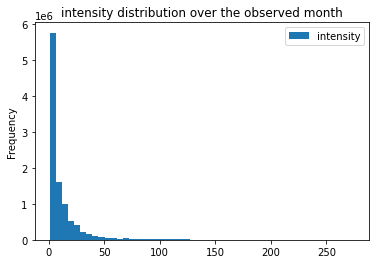

In [28]:
totalIntensity.plot.hist(bins=50)
plt.title('intensity distribution over the observed month')

In [29]:
df_hour = df.withColumn('hour', hour("timestamp").alias("hour"))
df_hour = df_hour.groupby('hour').agg({'intensity':'sum'}).toPandas()

([<matplotlib.axis.XTick at 0x1a0699e20>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

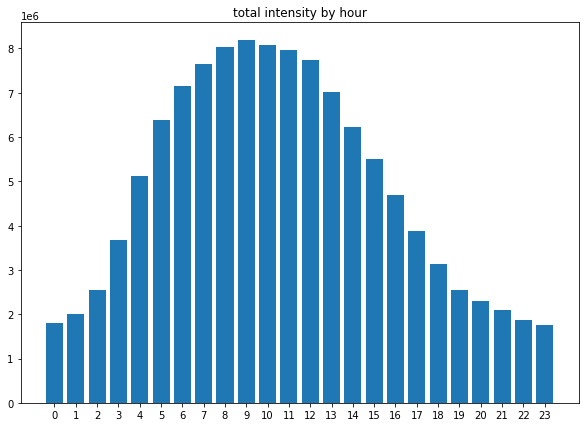

In [30]:
plt.figure(figsize=(10, 7))
plt.bar(df_hour.hour, df_hour['sum(intensity)'])
plt.title('total intensity by hour')
plt.xticks(range(0, 24))

In [31]:
df_week = df.withColumn('dayofweek', dayofweek("timestamp").alias("dayofweek"))
df_week = df_week.groupby('dayofweek').agg({'intensity':'sum'}).toPandas()

([<matplotlib.axis.XTick at 0x19e00b190>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

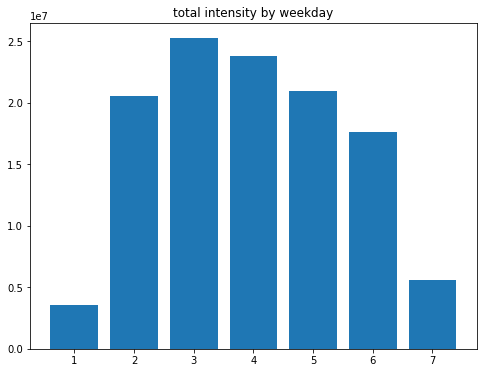

In [32]:
plt.figure(figsize=(8, 6))
plt.bar(df_week.dayofweek, df_week['sum(intensity)'])
plt.title('total intensity by weekday')
plt.xticks(range(1, 8))

## understanding segment names/roads etc.

In [33]:
# check segment names and attached segment ids

segment_names = df.groupby('segment_name').agg(collect_set('segment_id')).toPandas()
segment_names.head()

,segment_name,collect_set(segment_id)
0,D00-001,"[40000000, 40000001]"
1,D00-002,"[40000010, 40000011]"
2,D00-003,"[40000021, 40000020]"
3,D00-004,"[40000031, 40000030]"
4,D00-005,"[40000040, 40000041]"


In [ ]:
# check ids for a segment name D00-001
segments[segments.segment_name == 'D00-001']

In [ ]:
segments_gdf[segments_gdf.segment_id == '40000001']

In [ ]:
# plot segments attached with a segment name 
ax = segments_gdf.plot(figsize=(10, 10))
segments_gdf[segments_gdf.segment_id == '40000000'].plot(color='red', marker='x', markersize=50, ax=ax)
segments_gdf[segments_gdf.segment_id == '40000001'].plot(marker='o', markersize=10, ax=ax)
ax.set_title('segment locations')

In [ ]:
# most segment names seem to have 2 segment ids associated with it, which seems to be overlapping, 

In [36]:
# segment name with locations
segment_name = df.select('segment_name', 'segment_road_name', 'segment_location').drop_duplicates(subset=['segment_name']).toPandas()

segment_name['lat'] = segment_name['segment_location'].apply(lambda x: x[0])
segment_name['lon'] = segment_name['segment_location'].apply(lambda x: x[1])
segment_name['lat'] = segment_name.lat.astype(float)
segment_name['lon'] = segment_name.lon.astype(float)
geometry = [Point(xy) for xy in zip(segment_name.lon, segment_name.lat)]
segment_name_gdf = GeoDataFrame(segment_name, crs="EPSG:4326", geometry=geometry)

Text(0.5, 1.0, 'segment name locations')

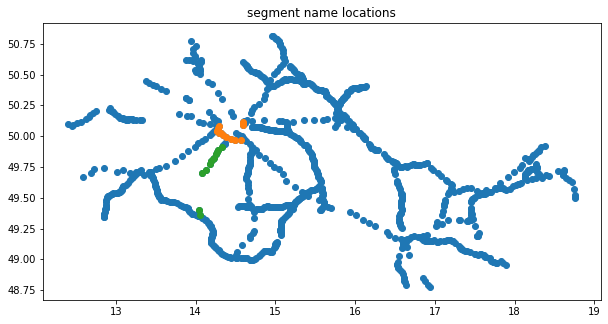

In [37]:
# plot segments
ax = segment_name_gdf.plot(figsize=(10, 10))
segment_name_gdf[segment_name_gdf.segment_road_name == 'D0'].plot(figsize=(10, 10), ax=ax)
segment_name_gdf[segment_name_gdf.segment_road_name == 'D4'].plot(figsize=(10, 10), ax=ax)
ax.set_title('segment name locations')

In [38]:
segment_name_gdf.to_csv('czech_roads.csv', index=False)

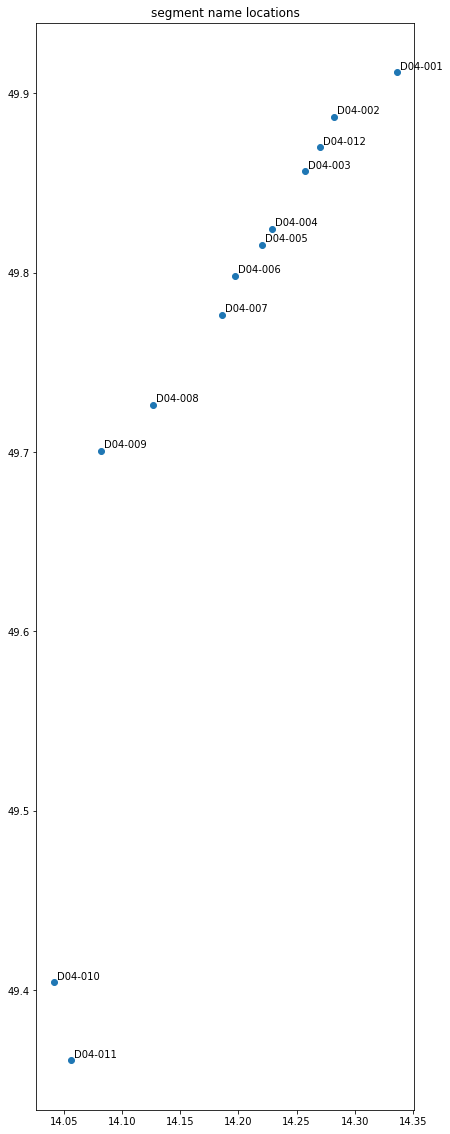

In [39]:
# ax = segment_name_gdf.plot(figsize=(10, 10))
temp = segment_name_gdf[segment_name_gdf.segment_road_name == 'D4']
ax = segment_name_gdf[segment_name_gdf.segment_road_name == 'D4'].plot(figsize=(20, 20))
ax.set_title('segment name locations')

for x, y, label in zip(temp.geometry.x, temp.geometry.y, temp.segment_name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

## Construct network

done manually, see the segment locations here: https://www.google.com/maps/d/u/1/viewer?mid=1T_1Wt-Rtw7xQf0jVkJluCUkRrImGtnc&ll=49.80533310364085%2C15.582455854149991&z=8

In [40]:
# contruct network edges

connections = pd.DataFrame({'segment_from':['D00-015', 'D05-017','I26-005', 
                                   'D05-014', 'D06-008', 'D07-006', 'I07-001', 'D07-001', 'D00-015', 'D06-001', 
                                   'D05-001', 'D05-001', 'I04-001', 'I04-001', 'D00-004', 'D00-004', 
                                   'I03-001', 'I03-001', 'D04-011', 'D04-011', 'I20-088', 'D03-013', 
                                   'D03-013', 'I19-011', 'I19-011', 'D03-001', 'D11-001', 'D11-001', 'D10-001', 
                                   'I12-001', 'I38-025', 'I38-025', 'I12-029', 'I12-029', 'I34-092', 
                                   'I34-092', 'D01-020', 'D01-020', 'D01-018', 'D01-018', 'D35-001', 
                                   'D35-001', 'I11-001', 'I11-001', 'D11-013', 'D11-013', 'I11-004', 'I35-071', 
                                   'I35-071', 'D35-016', 'D35-016', 'D02-001', 'D02-001', 'I52-001', 
                                   'I52-001', 'I50-001', 'I50-001', 'I43-038', 'I43-038', 'D46-001', 
                                   'D46-001', 'I35-126', 'D46-011', 'D46-011', 'I46-001', 'D35-008', 
                                   'D35-008', 'I35-124', 'D01-051', 'D01-051', 'D35-013', 'D48-001', 
                                   'D48-001', 'I58-013', 'I58-013', 'D56-007', 'D56-007', 'I11-005', 
                                   'I11-020', 'I11-020'], 'segment_to':
                            ['D06-001', 'I26-005', 'D05-016', 'I20-005', 'I06-025', 'I07-002', 'D07-005', 
                            'D00-015', 'D06-001', 'D00-014', 'D00-012', 'D00-013', 'D00-007', 'D00-006', 
                            'D01-005', 'D01-004', 'D01-008', 'D01-007', 'I20-052', 'I20-053', 'I34-001', 
                            'I34-001', 'I34-002', 'D03-003', 'D03-002', 'I03-027', 'D00-003', 'D00-002', 
                            'D00-001', 'D00-003', 'D11-006', 'D11-005', 'I38-033', 'I38-034', 'I38-079', 
                            'I38-080', 'I38-093', 'I38-092', 'I34-077', 'I34-078', 'D11-012', 'D11-011', 
                            'D11-012', 'D11-013', 'I35-071', 'I35-070', 'I33-001', 'I33-001', 'I11-004', 
                            'I35-079', 'I35-080', 'D01-032', 'D01-033', 'D01-032', 'D01-031', 'D01-037', 
                            'D01-038', 'I35-106', 'I35-105', 'D01-040', 'D01-041', 'D35-007', 'D35-007', 
                            'I46-001', 'D35-007', 'I46-001', 'D46-011', 'D35-002', 'D35-013', 'D01-050', 
                            'D01-050', 'D01-052', 'D01-053', 'D48-008', 'D48-007', 'D48-003', 'D48-011', 
                            'D48-006', 'D01-058', 'D01-059']})
connections.head()

,segment_from,segment_to
0,D00-015,D06-001
1,D05-017,I26-005
2,I26-005,D05-016
3,D05-014,I20-005
4,D06-008,I06-025


In [41]:
# construct edges within roads, where segments are names in consecutive numbers

within_roads = []

for road in segment_name_gdf.segment_road_name.unique():
    
    road_temp = segment_name_gdf[segment_name_gdf.segment_road_name == road]
    road_temp['segment_from'] = road_temp[['segment_name']].shift()
    road_temp.rename(columns={'segment_name':'segment_to'}, inplace=True)
    within_roads.append(road_temp[['segment_from', 'segment_to']])

/Users/devashishkhulbe/opt/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/devashishkhulbe/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [42]:
# concat everything

within_roads.append(connections)
segment_connections = pd.concat(within_roads)
segment_connections.dropna(inplace=True)
segment_connections.reset_index(drop=True, inplace=True)
segment_connections

,segment_from,segment_to
0,D00-001,D00-002
1,D00-002,D00-003
2,D00-003,D00-004
3,D00-004,D00-005
4,D00-005,D00-006
...,...,...
1161,D56-007,D48-003
1162,D56-007,D48-011
1163,I11-005,D48-006
1164,I11-020,D01-058


In [43]:
import networkx as nx

#creare a directed graph subway network
segments_graph=nx.Graph()
for i in segment_connections.index:
    segments_graph.add_edge(segment_connections.segment_from[i],segment_connections.segment_to[i])   
    
#create a dictionary of subway stations by name and location
StPos={segment_name_gdf.segment_name[c]:(segment_name_gdf.lon[c],
                                         segment_name_gdf.lat[c]) for c in segment_name_gdf.index}
# StName={segment_name_gdf.id[c]:segment_name_gdf.name[c] for c in Stations.index}

In [44]:
# some additional fixes

segments_graph.remove_edge('D06-017', 'D06-018')
segments_graph.remove_edge('D06-007', 'D06-008')
segments_graph.remove_edge('D06-006', 'D06-007')
segments_graph.remove_edge('D05-025', 'D05-024')
segments_graph.remove_edge('I07-002', 'I07-003')
segments_graph.remove_edge('D07-005', 'D07-006')
segments_graph.remove_edge('I11-005', 'I11-004')
segments_graph.remove_edge('I35-126', 'I35-127')
segments_graph.remove_edge('I35-129', 'I35-128')
segments_graph.remove_edge('I11-016', 'I11-015')
segments_graph.remove_edge('D35-015', 'D35-014')
segments_graph.remove_edge('I35-140', 'I35-141')

segments_graph.add_edge('D06-007', 'D06-021')
segments_graph.add_edge('D06-007', 'I06-001')
segments_graph.add_edge('D06-006', 'D06-018')
segments_graph.add_edge('I07-003', 'D07-010')

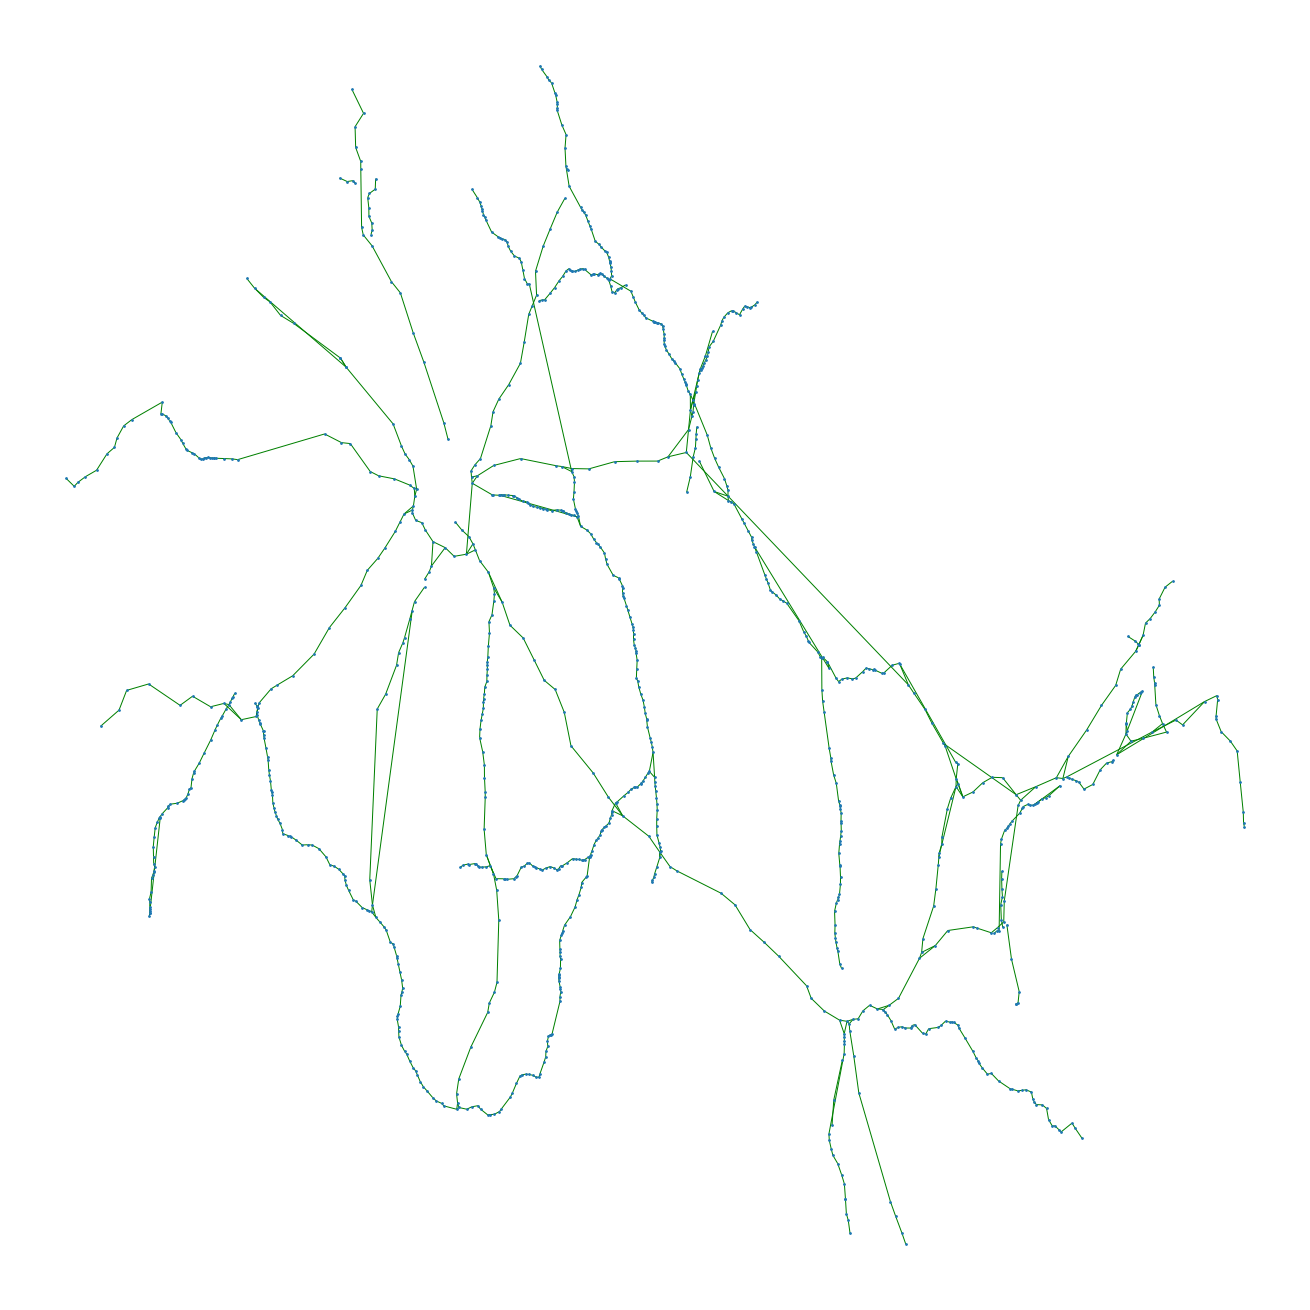

In [45]:
#visualize the subway newtork
plt.figure(figsize = (18,18))
nx.draw(segments_graph,pos=StPos,with_labels=False,arrows=False,node_size=3,width=1,edge_color='green')

In [46]:
segment_attribure = df.select('segment_id', 'segment_name').drop_duplicates().toPandas()
segment_attribure.head()

,segment_id,segment_name
0,40001030,D11-008
1,40002711,I12-014
2,40003421,I19-021
3,40004461,I20-084
4,40005141,I03-016


In [47]:
# save

with open("czech_road_network.p", 'wb') as f:
    pickle.dump(segments_graph, f)
    
# with open("czech_road_network.p", 'rb') as f:  # notice the r instead of w
#     G_loaded = pickle.load(f)

## Understanding segments and roads

In [48]:
# segment_full_name

segment_fullnames = df.groupby('segment_fullname').agg(collect_set('segment_id')).toPandas()
segment_fullnames.head()

,segment_fullname,collect_set(segment_id)
0,D00-001: Praha-Chlumecká - Praha-Satalice,[40000001]
1,D00-001: Praha-Satalice - Praha-Chlumecká,[40000000]
2,D00-002: Praha-Chlumecká - Praha-Horní Počernice,[40000010]
3,D00-002: Praha-Horní Počernice - Praha-Chlumecká,[40000011]
4,D00-003: Praha-Běchovice - Praha-Horní Počernice,[40000021]


In [49]:
# segments full names which have mutiple ids

segment_fullnames['id_length'] = segment_fullnames['collect_set(segment_id)'].apply(lambda x:
                                                                                    len(x))
segment_fullnames[segment_fullnames.id_length > 1]

,segment_fullname,collect_set(segment_id),id_length
434,D35-001: Opatovice nad Labem - Sedlice,"[40001281, 40015321]",2
435,D35-001: Sedlice - Opatovice nad Labem,"[40015320, 40001280]",2
520,D55-003: Otrokovice-sever - Otrokovice-východ,"[40015380, 40001970]",2
521,D55-003: Otrokovice-východ - Otrokovice-sever,"[40001971, 40015381]",2
536,D56-006: Frýdek-Místek - Staříč,"[40002021, 40015151]",2
537,D56-006: Staříč - Frýdek-Místek,"[40002020, 40015150]",2
2012,I47-013: Lipník nad Bečvou 1 - Lipník nad Bečv...,"[40015340, 40012160]",2


In [ ]:
# check for a particular segment full name

segments_gdf[segments_gdf.segment_id == '40001281']

In [ ]:
segments_gdf[segments_gdf.segment_id == '40015321']

In [ ]:
# repeated location

In [ ]:
# check another

segments_gdf[segments_gdf.segment_id == '40015320']

In [ ]:
segments_gdf[segments_gdf.segment_id == '40001280']

In [ ]:
# another repeated


In [51]:
# roads

df.select('segment_road_name').distinct().count()

42

In [52]:
# roads with segment ids

roads = df.groupby('segment_road_name').agg(collect_set('segment_id')).toPandas()
roads.head()

,segment_road_name,collect_set(segment_id)
0,7,"[40010741, 40010750, 40010751, 40010761, 40010..."
1,D5,"[40001771, 40001870, 40012270, 40001791, 40001..."
2,D7,"[40002440, 40002251, 40002240, 40002441, 40015..."
3,11,"[40010781, 40002461, 40002530, 40002550, 40002..."
4,3,"[40004991, 40005251, 40005051, 40005001, 40005..."


In [53]:
# roads with segment names

roads = df.groupby('segment_road_name').agg(collect_set('segment_name')).toPandas()
roads.head()

,segment_road_name,collect_set(segment_name)
0,7,"[I07-003, I07-001, I07-002]"
1,D5,"[D05-022, D05-007, D05-024, D05-008, D05-009, ..."
2,D7,"[D07-002, D07-007, D07-001, D07-003, D07-008, ..."
3,11,"[I11-012, I11-020, I11-003, I11-017, I11-014, ..."
4,3,"[I03-024, I03-023, I03-025, I03-014, I03-001, ..."


In [54]:
# roads with locations
roads = df.select('segment_road_name', 'segment_location').drop_duplicates().toPandas()
roads.head()

,segment_road_name,segment_location
0,D3,"(49.2087372714, 14.7131620552)"
1,16,"(50.4252548535, 15.3486218834)"
2,19,"(49.4063686168, 14.7228327035)"
3,26,"(49.606722041, 13.1199451473)"
4,35,"(50.7397532292, 15.0520580344)"


Text(0.5, 1.0, 'avg intensity by road')

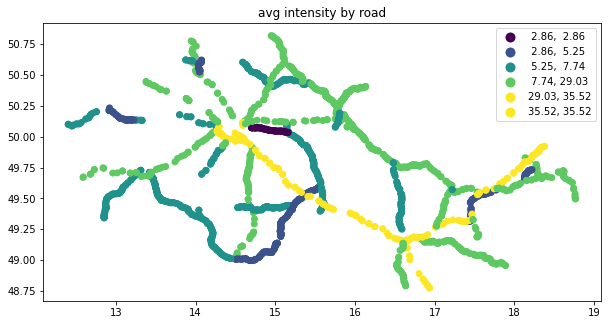

In [55]:
# avg intensity by road

roads_avgInt = df.groupby('segment_road_name').agg({'intensity': 'mean'}).toPandas()
roads['lat'] = roads['segment_location'].apply(lambda x: x[0])
roads['lon'] = roads['segment_location'].apply(lambda x: x[1])
roads['lat'] = roads.lat.astype(float)
roads['lon'] = roads.lon.astype(float)
geometry = [Point(xy) for xy in zip(roads.lon, roads.lat)]
roads_gdf = GeoDataFrame(roads, crs="EPSG:4326", geometry=geometry)
roads_avgIntensity = roads_gdf.merge(roads_avgInt, on='segment_road_name')
roads_avgIntensity.plot(column='avg(intensity)', k=10, scheme='Percentiles', figsize=(10, 10), 
                    legend=True)
plt.title('avg intensity by road')

Text(0.5, 1.0, 'avg speed by road')

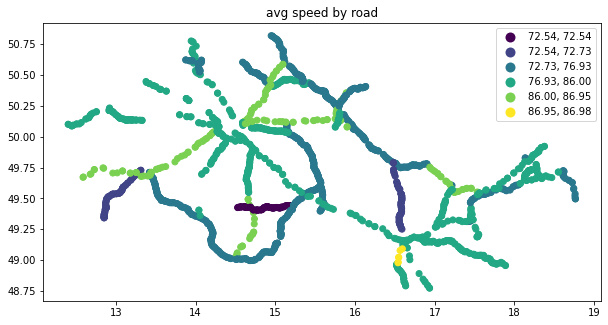

In [56]:
# avg speed by road

roads_avgSp = df.groupby('segment_road_name').agg({'avg_speed': 'mean'}).toPandas()
roads_avgSpeed = roads_gdf.merge(roads_avgSp, on='segment_road_name')
roads_avgSpeed.plot(column='avg(avg_speed)', k=10, scheme='Percentiles', figsize=(10, 10), 
                    legend=True)
plt.title('avg speed by road')

## Aggregation on 15min intervals

In [57]:
seconds = 900  # aggregation window
epoch = (col("timestamp").cast("timestamp").cast("bigint") / seconds).cast(
    "bigint"
) * seconds

df_1 = df.withColumn("epoch", epoch)
df_1 = df_1.withColumn("intensity", df_1["intensity"].cast(IntegerType()))

min_epoch, max_epoch = df_1.select(min("epoch"), max("epoch")).first()

ref = spark.range(min_epoch, max_epoch + seconds, seconds).toDF("epoch")

In [58]:
df_ = (
    ref.join(df_1, "epoch", "left")
    .withColumn("ts_resampled", timestamp_seconds("epoch"))
    .groupBy("segment_name", "ts_resampled")
    .sum("intensity")
    .orderBy("ts_resampled")
    .fillna(0, subset=["sum(intensity)"])
)

# df_ = (
#     ref.join(df_1, "epoch", "left")
#     .withColumn("ts_resampled", timestamp_seconds("epoch"))
#     .groupBy("segment_name", "ts_resampled")
#     .mean("speed_variance")
#     .orderBy("ts_resampled")
#     .fillna(0, subset=["avg(speed_variance)"])
# )

In [59]:
df_.show()

23/02/11 17:12:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/11 17:12:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
+------------+-------------------+--------------+
|segment_name|       ts_resampled|sum(intensity)|
+------------+-------------------+--------------+
|     D00-001|2022-01-17 20:00:00|           100|
|     D00-002|2022-01-17 20:00:00|           108|
|     D00-003|2022-01-17 20:00:00|           123|
|     D00-004|2022-01-17 20:00:00|           134|
|     D00-005|2022-01-17 20:00:00|           138|
|     D00-006|2022-01-17 20:00:00|           122|
|     D00-007|2022-01-17 20:00:00|           132|
|     D00-008|2022-01-17 20:00:00|           130|
|     D00-009|2022-01-17 20:00:00|           121|
|     D00-010|2022-01-17 20:00:00|           111|
|     D00-011|2022-01-17 20:00:00|           120|
|     D00-012|2022-01-17 20:00:00|           111|
|     D00-013|20

In [60]:
df__ = df_.groupBy("ts_resampled").pivot('segment_name').agg(sum('sum(intensity)')).toPandas()
# df__.to_csv('intensity_15min.csv', index=False)

Data pre-processing:

Drop the last 7% of the observations.

If more than 25% of time series for a node is missed —> drop a node.

Intensity NaN values handling: propagate last valid observation forward to next valid; propagate valid observation back to the previous valid. (ffil -> bfill).

Speed NaN values handling: propagate last valid observation forward to next valid; propagate valid observation back to the previous valid. (ffil -> bfill).


In [ ]:
# read processed data
inten_15 = pd.read_csv('intensity_15min.csv')

# clean
inten_15 = inten_15.loc[:int(len(inten_15) * 0.93)]
inten_15 = inten_15.loc[:, inten_15.isna().sum() / len(inten_15) < 0.25]
inten_15 = inten_15.fillna(method='ffill')
inten_15 = inten_15.fillna(0)

with open("cz_road_network.p", 'rb') as f:  # load road network
    G_loaded = pickle.load(f)


# keep the filtered nodes in the network    
nodes = inten_15.columns[1:].to_list()
G_loaded = nx.Graph(G_loaded.subgraph(nodes))